In [46]:
import pandas as pd

In [47]:
df = pd.read_parquet('../data/updated_dataset.parquet.gzip')

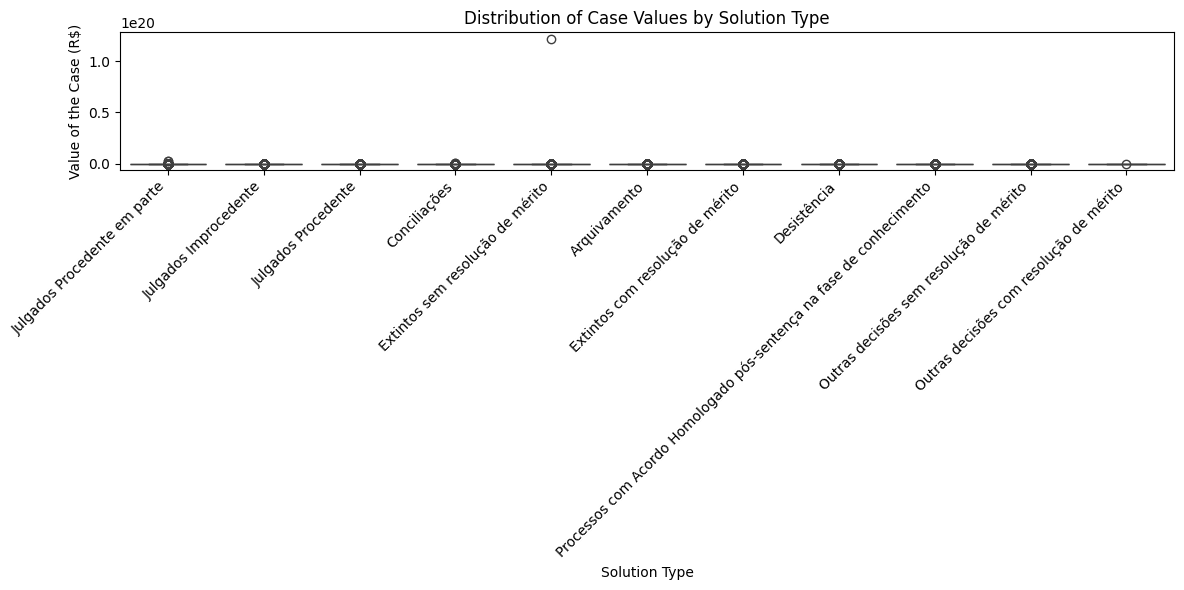

In [49]:
import seaborn as sns

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x='TIPO DE SOLUÇÃO', y='VALOR DA CAUSA', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Case Values by Solution Type')
plt.ylabel('Value of the Case (R$)')
plt.xlabel('Solution Type')
plt.tight_layout()
plt.show()